## Imports

In [1]:
import os
os.chdir("../")
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import compare_psnr
import tensorflow as tf
from data.dataset import Dataset
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

In [3]:
class lca_params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_768_mnist"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    self.overwrite_analysis_log = False

class ae_params(object):
  def __init__(self):
    self.model_type = "ae"
    self.model_name = "ae_768_mnist"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    self.overwrite_analysis_log = False
    
class sae_params(object):
  def __init__(self):
    self.model_type = "sae"
    self.model_name = "sae_768_mnist"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    self.overwrite_analysis_log = False

params_list = [ae_params()]
for params in params_list:
  params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+params.model_name)

In [4]:
analyzer_list = [ap.get_analyzer(params.model_type) for params in params_list]
for analyzer, params in zip(analyzer_list, params_list):
  analyzer.setup(params)
  analyzer.model.setup(analyzer.model_params)
  analyzer.load_analysis(save_info=params.save_info)
  analyzer.model_name = params.model_name

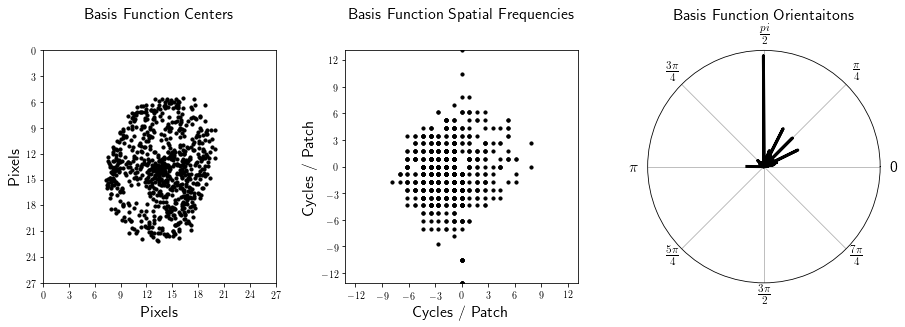

In [5]:
loc_freq_fig = pf.plot_loc_freq_summary(analyzer.bf_stats)
loc_freq_fig.savefig(analyzer.analysis_out_dir+"/vis/location_frequency_centers.png")

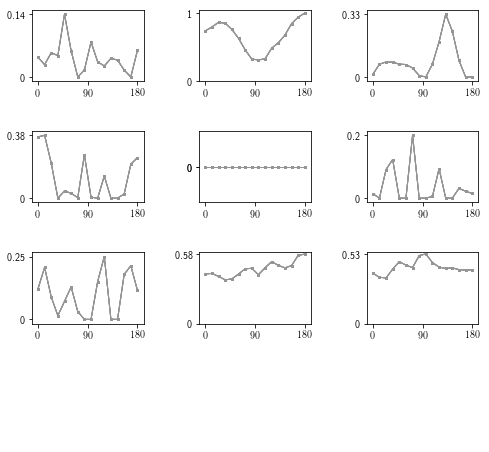

In [10]:
ot_fig = pf.plot_contrast_orientation_tuning(range(9),#analyzer.ot_grating_responses["neuron_indices"],
  analyzer.ot_grating_responses["contrasts"],
  analyzer.ot_grating_responses["orientations"],
  analyzer.ot_grating_responses["mean_responses"], figsize=(8,8))
ot_fig.savefig(analyzer.analysis_out_dir+"/vis/orientation_tuning_sm.pdf")

In [43]:
def center_curve(tuning_curve):
  """
  Centers a curve about its preferred orientation
  """
  return np.roll(tuning_curve, (len(tuning_curve) // 2) - np.argmax(tuning_curve))

def compute_fwhm(centered_ot_curve, corresponding_angles_deg):
  """
  Calculates the full width at half maximum of the tuning curve

  Result is expressed in degrees to make it a little more intuitive. The curve
  is often NOT symmetric about the maximum value so we don't do any fitting and
  we return the FULL width

  Parameters
  ----------
  centered_ot_curve : ndarray
      A 1d array of floats giving the value of the ot curve, at an orientation
      relative to the *preferred orientation* which is given by the angles in
      corresponding_angles_deg. This has the maximum orientation in the
      center of the array which is nicer for visualization.
  corresponding_angles_deg : ndarray
      The orientations relative to preferred orientation that correspond to
      the values in centered_ot_curve

  Returns
  -------
  half_max_left : float
      The position of the intercept to the left of the max
  half_max_right : float
      The position of the intercept to the right of the max
  half_max_value : float
      Mainly for plotting purposes, the actual curve value that corresponds
      to the left and right points
  """
  max_idx = np.argmax(centered_ot_curve)
  min_idx = np.argmin(centered_ot_curve)
  max_val = centered_ot_curve[max_idx]
  min_val = centered_ot_curve[min_idx]
  midpoint = (max_val / 2) + (min_val / 2)
  # find the left hand point
  idx = max_idx
  while centered_ot_curve[idx] > midpoint:
    idx -= 1
    if idx == -1:
      # the width is *at least* 90 degrees
      half_max_left = -90.
      break
  if idx > -1:
    # we'll linearly interpolate between the two straddling points
    # if (x2, y2) is the coordinate of the point below the half-max and
    # (x1, y1) is the point above the half-max, then we can solve for x3, the
    # x-position of the point that corresponds to the half-max on the line
    # that connects (x1, y1) and (x2, y2)
    half_max_left = (((midpoint - centered_ot_curve[idx])
      * (corresponding_angles_deg[idx+1] - corresponding_angles_deg[idx])
      / (centered_ot_curve[idx+1] - centered_ot_curve[idx]))
      + corresponding_angles_deg[idx])
  # find the right hand point
  idx = max_idx
  while centered_ot_curve[idx] > midpoint:
    idx += 1
    if idx == len(centered_ot_curve):
      # the width is *at least* 90
      half_max_right = 90.
      break
  if idx < len(centered_ot_curve):
    # we'll linearly interpolate between the two straddling points again
    half_max_right = (((midpoint - centered_ot_curve[idx-1])
      * (corresponding_angles_deg[idx] - corresponding_angles_deg[idx-1])
      / (centered_ot_curve[idx] - centered_ot_curve[idx-1]))
      + corresponding_angles_deg[idx-1])
  return half_max_left, half_max_right, midpoint

def compute_circ_var(centered_ot_curve, corresponding_angles_rad):
  """
  From
  DL Ringach, RM Shapley, MJ Hawken (2002) - Orientation Selectivity in Macaque V1:
  Diversity and Laminar Dependence
  
  Computes the circular variance of a tuning curve and returns vals for plotting

  This is a scale-invariant measure of how 'oriented' a curve is in some
  global sense. It wraps reponses around the unit circle and then sums their
  vectors, resulting in an average vector, the magnitude of which indicates
  the strength of the tuning. Circular variance is an index of 'orientedness'
  that falls in the interval [0.0, 1.0], with 0.0 indicating a delta function
  and 1.0 indicating a completely flat tuning curve.

  Parameters
  ----------
  centered_ot_curve : ndarray
      A 1d array of floats giving the value of the ot curve, at an orientation
      relative to the *preferred orientation* which is given by the angles in
      corresponding_angles_rad. This has the maximum orientation in the
      center of the array which is nicer for visualization.
  corresponding_angles_rad : ndarray
      The orientations relative to preferred orientation that correspond to
      the values in centered_ot_curve

  Returns
  -------
  numerator_sum_components : ndarray
      The complex values the are produced from r * np.exp(j*2*theta). These
      are the elements that get summed up in the numerator
  direction_vector : complex64 or complex128
      This is the vector that points in the direction of *aggregate* tuning.
      its magnitude is upper bounded by 1.0 which is the case when only one
      orientation has a nonzero value. We can plot it to get an idea of how
      tuned a curve is
  circular_variance : float
      This is 1 minus the magnitude of the direction vector. It represents and
      index of 'global selectivity'
  """
  # in the original definition, angles are [0, 2*np.pi] so the factor of 2
  # in the exponential wraps the phase twice around the complex circle,
  # placing responses that correspond to angles pi degrees apart
  # onto the same place. We know there's a redudancy in our responses at pi
  # offsets so our responses get wrapped around the unit circle once.
  numerator_sum_components = (centered_ot_curve
    * np.exp(1j * 2 * corresponding_angles_rad))
  direction_vector = (np.sum(numerator_sum_components)
    / np.sum(centered_ot_curve))
  circular_variance = 1 - np.abs(direction_vector)
  return (numerator_sum_components, direction_vector, circular_variance)

def compute_osi(centered_ot_curve):
  """
  Compute the Orientation Selectivity Index.

  This is the most coarse but popular measure of selectivity. It really
  doesn't tell you much. It just measures the maximum response relative to
  the minimum response.

  Parameters
  ----------
  centered_ot_curve : ndarray
      A 1d array of floats giving the value of the ot curve, at an orientation
      relative to the *preferred orientation*

  Returns
  -------
  osi : float
      This is (a_max - a_orth) / (a_max + a_orth) where a_max is the maximum
      response across orientations when orientation responses are
      *averages* over phase. a_orth is the orientation which is orthogonal to
      the orientation which produces a_max.
  """
  max_val = np.max(centered_ot_curve)
  # Assume that orthogonal orientation is at either end of the curve modulo 1
  # bin (if we had like an even number of orientation values)
  orth_val = centered_ot_curve[0]
  osi = (max_val - orth_val) / (max_val + orth_val)
  return osi

In [47]:
from matplotlib.ticker import FormatStrFormatter

def plot_circular_variance(cv_data, max_bfs_per_fig=400, title="", save_filename=None):
  assert np.sqrt(max_bfs_per_fig) % 1 == 0, "Pick a square number for max_bfs_per_fig"
  orientations = (np.pi * np.arange(len(cv_data))
    / len(cv_data)) - (np.pi/2) # relative to preferred
  num_bfs = len(cv_data)
  num_bf_figs = int(np.ceil(num_bfs / max_bfs_per_fig))
  # this determines how many ot curves are aranged in a square grid within
  # any given figure
  if num_bf_figs > 1:
    bfs_per_fig = max_bfs_per_fig
  else:
    squares = [x**2 for x in range(1, int(np.sqrt(max_bfs_per_fig))+1)]
    bfs_per_fig = squares[bisect.bisect_left(squares, num_bfs)]
  plot_sidelength = int(np.sqrt(bfs_per_fig))
  bf_idx = 0
  bf_figs = []
  for in_bf_fig_idx in range(num_bf_figs):
    fig = plt.figure(figsize=(32, 32))
    plt.suptitle(title + ', fig {} of {}'.format(
      in_bf_fig_idx+1, num_bf_figs), fontsize=20)
    subplot_grid = gridspec.GridSpec(plot_sidelength, plot_sidelength,
      wspace=0.4, hspace=0.4)
    fig_bf_idx = bf_idx % bfs_per_fig
    while fig_bf_idx < bfs_per_fig and bf_idx < num_bfs:
      #if bf_idx % 100 == 0:
      #  print("plotted ", bf_idx, " of ", num_bfs, " circular variance plots")
      ## print("sum vector: ", np.real(cv_data[bf_idx][1]), np.imag(cv_data[bf_idx][1]))
      ax = plt.Subplot(fig, subplot_grid[fig_bf_idx])
      ax.plot(np.real(cv_data[bf_idx][0]), np.imag(cv_data[bf_idx][0]),
              c='g', linewidth=0.5)
      ax.scatter(np.real(cv_data[bf_idx][0]), np.imag(cv_data[bf_idx][0]),
                 c='g', s=4)
      ax.quiver(np.real(cv_data[bf_idx][1]), np.imag(cv_data[bf_idx][1]),
                angles='xy', scale_units='xy', scale=1.0, color='b',
                width=0.01)
      # ax.quiver(0.5, 0.5, color='b')
      ax.axvline(x=0.0, color='k', linestyle='--', alpha=0.6, linewidth=0.3)
      ax.axhline(y=0.0, color='k', linestyle='--', alpha=0.6, linewidth=0.3)
      ax.yaxis.set_major_formatter(FormatStrFormatter('%0.2g'))
      xaxis_size = max(np.max(np.real(cv_data[bf_idx][0])), 1.0)
      yaxis_size = max(np.max(np.imag(cv_data[bf_idx][0])), 1.0)
      ax.set_yticks([-1. * yaxis_size, yaxis_size])
      ax.set_xticks([-1. * xaxis_size, xaxis_size])
      # put the circular variance index in the upper left
      ax.text(0.02, 0.97, 'CV: {:.2f}'.format(cv_data[bf_idx][2]),
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes, color='b', fontsize=10)
      fig.add_subplot(ax)
      fig_bf_idx += 1
      bf_idx += 1
    if save_filename is not None:
      filename_split = os.path.split(save_filename)
      save_filename = filename_split[0]+str(in_bf_fig_idx).zfill(2)+"_"+filename_split[1]
      fig.savefig(save_filename)
      plt.close(fig)
      bf_figs.append(None)
    else:
      bf_figs.append(fig)
  if save_filename is None:
    plt.show()
  return bf_figs

In [48]:
contrast_idx = -1
num_orientation_samples = len(analyzer.ot_grating_responses['orientations'])
corresponding_angles_deg = (180 * np.arange(num_orientation_samples) / num_orientation_samples) - 90
corresponding_angles_rad = (np.pi * np.arange(num_orientation_samples) / num_orientation_samlpes) - (np.pi/2)

metrics_list = {"fwhm":[], "circ_var":[], "osi":[], "skipped_indices":[]}
for bf_idx in range(analyzer.bf_stats["num_outputs"]):
  ot_curve = center_curve(analyzer.ot_grating_responses["mean_responses"][bf_idx, contrast_idx, :])
  if np.max(ot_curve) - np.min(ot_curve) == 0:
    metrics_list["skipped_indices"].append(bf_idx)
  else:
    fwhm = compute_fwhm(ot_curve, corresponding_angles_deg)
    metrics_list["fwhm"].append(fwhm)
    circ_var = compute_circ_var(ot_curve, corresponding_angles_rad)
    metrics_list["circ_var"].append(circ_var)
    osi = compute_osi(ot_curve)
    metrics_list["osi"].append(osi)

In [49]:
fig = plot_circular_variance(metrics_list["circ_var"], max_bfs_per_fig=144, title="Circular Variance",
  save_filename=analyzer.analysis_out_dir+"/vis/circular_variance.png")

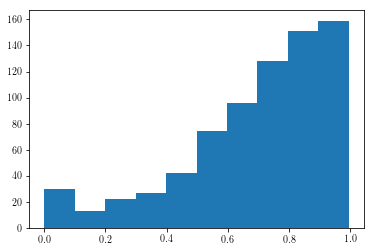

In [41]:
plt.hist([val[2] for val in metrics_list["circ_var"]])
plt.show()

In [ ]:
#cross_fig = pf.plot_masked_orientation_tuning(co_bf_indices, co_mask_orientations, co_base_mean_responses, analyzer.co_grating_responses["test_mean_responses"])
cross_fig = pf.plot_masked_orientation_tuning(co_bf_indices, co_mask_orientations, co_base_mean_responses, co_test_mean_responses)
cross_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_cross_orientation_tuning.pdf")

In [ ]:
cross_contrast_fig = pf.plot_plaid_contrast_tuning(co_bf_indices, co_contrasts, co_contrasts, co_base_orientations,
  co_mask_orientations, co_test_mean_responses)
cross_contrast_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_cross_contrast_orientation_tuning.pdf")

In [ ]:
#grating = lambda bf_idx,orientation,phase,contrast:dp.generate_grating(
#  *dp.get_grating_params(bf_stats=analyzer.bf_stats, bf_idx=bf_idx, orientation=orientation,
#  phase=phase, contrast=contrast, diameter=-1)).reshape(16,16)
#
#bf_idx = 29
#bf = analyzer.evals["weights/phi:0"].T[co_bf_indices[bf_idx],:].reshape(16,16)
#base_stim = grating(co_bf_indices[bf_idx], co_base_orientations[bf_idx], co_phases[0], 0.5)
#mask_stim = grating(co_bf_indices[bf_idx], orthogonal_orientations[bf_idx], co_phases[5], 0.5)
#test_stim = base_stim + mask_stim
#
#all_min = np.min(np.stack([base_stim, mask_stim, test_stim]))
#all_max = np.max(np.stack([base_stim, mask_stim, test_stim]))
#
#fig, axes = plt.subplots(4)
#axes[0] = pf.clear_axis(axes[0])
#axes[1] = pf.clear_axis(axes[1])
#axes[2] = pf.clear_axis(axes[2])
#axes[3] = pf.clear_axis(axes[3])
#axes[0].imshow(bf, cmap="Greys_r")
#axes[1].imshow(base_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#axes[2].imshow(mask_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#axes[3].imshow(test_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#plt.show()
#fig.savefig("/home/dpaiton/tmp_figs/"+analysis_params.model_name+"_ex_cross_stim.png")

In [ ]:
#constructed_bfs = np.zeros_like(analyzer.evals["weights/phi:0"].T)
#for bf_idx in range(constructed_bfs.shape[0]):
#  params = dp.get_grating_params(analyzer.bf_stats, bf_idx)
#  grating = dp.generate_grating(*params)
#  constructed_bfs[bf_idx,...] = grating.reshape(256)
#fig = pf.plot_data_tiled(constructed_bfs)

### compute iso_response_contrast curves

In [ ]:
outputs = analyzer.iso_response_contrasts(analyzer.bf_stats, base_contrast=0.5, contrast_resolution=0.01,
  closeness=0.01, num_alt_orientations=4, orientations=np.linspace(0.0, np.pi, 16),
  phases = np.linspace(-np.pi, np.pi, 12), neuron_indices=[52,53,54], diameter=-1,
  scale=analyzer.analysis_params.input_scale)

In [ ]:
outputs["iso_response_parameters"][0]